# Bias-correcting climate data and generating future streamflows with RAVEN

This notebook shows how to bias-correct climate data to drive a hydrological model and get future streamflow values.

In [1]:
# This entire section is cookie-cutter template to allow calling the servers and instantiating the connection
# to the WPS server. Do not modify this block.

from pathlib import Path
from urllib.request import urlretrieve
from zipfile import ZipFile
import glob
import json
import os
import datetime as dt
import tempfile

from birdy import WPSClient
from matplotlib import pyplot as plt
import xclim
from xclim import sdba
import fiona
import netCDF4 as nc
import numpy as np
import rioxarray
import shapely
import xarray as xr


from example_data import TESTDATA

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
url="http://localhost:9099"
wps = WPSClient(url)

# Temporary directory to store meteorological data
tmp = Path(tempfile.mkdtemp())

In [2]:
# We will first need to process the catchment boundaries from the zipped shapefile.
# Users can provide shapefiles of their own or use the region selection tools to define
# a watershed. This is necessary to obtain the latitude and longitude of the catchment that
# we need to extract from the climate model data and reference data.

# The shapefile of the catchment. All files (.shp, .shx, etc.) must be zipped into one file. "vec" is a string
# or Posix Path pointing to the zipped watershed contour file location.
vec = TESTDATA['watershed_vector']
print("The file location is: " + str(vec))

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = 'HMETS'

# Extract the contours and lat/long bounding boxes
ZipFile(vec,'r').extractall(tmp)
shp = list(tmp.glob("*.shp"))[0]
vector = fiona.open(shp, "r")

lon_min=vector.bounds[0]
lon_max=vector.bounds[2]
lat_min=vector.bounds[1]
lat_max=vector.bounds[3]

# Get access to the geometry using the fiona API
shdf = [vector.next()["geometry"]]

# From the shapefile, call the PAVICS-Hydro service to extract properties such as centroid lat/long, elevation and area.
resp = wps.shape_properties(shape=str(vec))
[properties, ]=resp.get(asobj=True)
prop = properties[0]
basin_area = prop['area']/1000000.0
basin_longitude = prop['centroid'][0]
basin_latitude = prop['centroid'][1]

# This uses the HydroSheds DEM
resp = wps.terrain_analysis(shape=str(vec), select_all_touching=True, projected_crs=3978)
properties, dem = resp.get(asobj=True)
basin_elevation=properties[0]['elevation']

print("Area: ", basin_area)
print("Elevation: ", basin_elevation)
print("Longitude: ", basin_longitude)
print("Latitude: ", basin_latitude)

The file location is: /home/ets/src/raventest/raven/tests/testdata/watershed_vector/LSJ_LL.zip


/home/ets/anaconda3/envs/raven/lib/python3.6/site-packages/ipykernel_launcher.py:25: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.


Area:  44877.1880529685
Elevation:  404.70766683028666
Longitude:  -72.69128332186324
Latitude:  49.501193631231935


In [ ]:
from xclim import subset

# For now, we use the centroid to extract a large-ish zone around the catchment center 
# (2 degrees x 2 degrees). We can replace this later with calls that are specific to 
# the points within a watershed.

lat=basin_latitude
lon=basin_longitude

# Access to the datasets for future and reference period (climate model) and historical (observed or proxy)
fut_data='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip5/nasa/nex-gddp-1.0/day_inmcm4_historical+rcp85_nex-gddp.ncml'
ref_data='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/simulations/bias_adjusted/cmip5/nasa/nex-gddp-1.0/day_inmcm4_historical+rcp45_nex-gddp.ncml'
hist_data="https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/gridded_obs/nrcan_v2.ncml"

# Open these datasets
ds_fut=xr.open_dataset(fut_data)
ds_ref=xr.open_dataset(ref_data)
ds_his=xr.open_dataset(hist_data)

# Subset the data to the desired location (2x2 degree box)
ds_fut_sub =subset.subset_bbox(ds_fut, lon_bnds=[lon-1, lon+1], lat_bnds=[lat-1, lat+1], start_date='2070', end_date='2079').mean(dim={'lat','lon'},keep_attrs=True)
ds_ref_sub =subset.subset_bbox(ds_ref, lon_bnds=[lon-1, lon+1], lat_bnds=[lat-1, lat+1], start_date='1971', end_date='1980').mean(dim={'lat','lon'},keep_attrs=True)
ds_his_sub =subset.subset_bbox(ds_his, lon_bnds=[lon-1, lon+1], lat_bnds=[lat-1, lat+1], start_date='1971', end_date='1980').mean(dim={'lat','lon'},keep_attrs=True)



In [5]:
# Apply the bias correction
import nc_time_axis
import cftime

# We will apply the statistics per month
group_month_nowindow = sdba.utils.Grouper('time.month')

# Here we specify that we want to use the Detrended Quantile Mapping method. See XCLIM documents for more methods and info.
Adj = sdba.DetrendedQuantileMapping(nquantiles=50, kind='+', group=group_month_nowindow)

# Train the model to find the correction factors
Adj.train(ds_ref_sub['pr'],ds_his_sub['pr'])

# Apply the factors to the future data to bias-correct
Scen_pr = Adj.adjust(ds_fut_sub['pr'], interp="linear")

# Display the adjustment factors
print(Adj.ds.af)

# Plot the corrected future data
#Scen_pr.plot() # IMPORT ERROR NC_TIME_AXIS?

print(Scen_pr)

## Repeat for temperature max
Adj.train(ds_ref_sub['tasmax'],ds_his_sub['tasmax'])

## Apply the factors to the future data to bias-correct
Scen_tasmax = Adj.adjust(ds_fut_sub['tasmax'], interp="linear")

# Repeat for tasmin
Adj.train(ds_ref_sub['tasmin'],ds_his_sub['tasmin'])
Scen_tasmin = Adj.adjust(ds_fut_sub['tasmin'], interp="linear")



<xarray.DataArray 'af' (month: 12, quantiles: 52)>
array([[ 1.97682583e-05,  2.32072987e-05,  1.33486042e-05,
         1.32034485e-05,  1.37144323e-05,  1.03450284e-05,
         7.02469108e-06,  7.10998896e-06,  4.76176501e-06,
         5.23352690e-06,  4.29149481e-06,  3.51422601e-06,
         3.60551199e-06,  3.99198962e-06,  3.99400655e-06,
         3.51984081e-06,  3.46935852e-06,  3.86028538e-06,
         1.75042101e-06,  1.38693596e-06,  7.68337377e-07,
        -3.86507554e-07,  7.38211838e-08,  5.73894931e-07,
        -3.54731819e-07, -8.03875455e-07,  2.32105940e-07,
         3.43001807e-07,  2.89644504e-07,  1.19026227e-06,
         1.54900577e-06,  1.53301164e-06,  9.43643022e-07,
         7.77251489e-07,  8.31329730e-07,  4.35515371e-07,
         9.15579030e-07,  1.14833402e-06,  2.70776377e-06,
        -4.70736140e-07, -3.01189949e-06, -3.42308795e-06,
        -3.28518579e-06, -3.36158391e-06, -5.40682960e-06,
        -8.28741720e-06, -1.27540031e-05, -1.36199735e-05,
     

/home/ets/anaconda3/envs/raven/lib/python3.6/site-packages/xclim/sdba/adjustment.py:67: UserWarning: train() was already called, overwriting old results.
  warn("train() was already called, overwriting old results.")
/home/ets/anaconda3/envs/raven/lib/python3.6/site-packages/xclim/sdba/adjustment.py:67: UserWarning: train() was already called, overwriting old results.
  warn("train() was already called, overwriting old results.")


In [142]:
from datetime import timedelta
# Ensure that the precipitation is non-negative, which can happen with some climate models
Scen_pr[Scen_pr<0] = 0

# Convert the data arrays to datasets
ds_Scen_pr = Scen_pr.to_dataset(name='pr')
ds_Scen_tasmax = Scen_tasmax.to_dataset(name='tasmax')
ds_Scen_tasmin = Scen_tasmin.to_dataset(name='tasmin')

t=ds_Scen_pr['time']
t=t - timedelta(hours=12)
ds_Scen_pr['time']=t
ds_Scen_tasmax['time']=t
ds_Scen_tasmin['time']=t

## Write these variables to a unique netcdf
bias_corrected_met = xr.merge([ds_Scen_pr,ds_Scen_tasmax,ds_Scen_tasmin], compat='override')
tsfile=tmp / 'ClimateModelFuture_ts4.nc'
bias_corrected_met.time.encoding['calendar']='365_DAY'
bias_corrected_met.to_netcdf(tsfile)

In [141]:
# ATTEMPT TO MAKE THE MODEL RUN BY REMOVING 12H TO BRING TO 00:00:00 instead of 12:00:00
t=bias_corrected_met['time']
from datetime import timedelta
t=t - timedelta(hours=12)
bias_corrected_met['time']=t
bias_corrected_met['pr'].time=t
bias_corrected_met['tasmax'].time=t
bias_corrected_met['tasmin'].time=t

bias_corrected_met.to_netcdf(tsfile)



AttributeError: cannot set attribute 'time' on a 'DataArray' object. Use __setitem__ styleassignment (e.g., `ds['name'] = ...`) instead of assigning variables.

In [147]:
bias_corrected_met['pr'][-1]

<xarray.DataArray 'pr' ()>
array(8.24073006e-09)
Coordinates:
    time     object 2079-12-31 00:00:00
Attributes:
    time:              32850.5
    standard_name:     precipitation_flux
    long_name:         Precipitation
    comment:           at surface; includes both liquid and solid phases from...
    units:             kg m-2 s-1
    original_name:     pr
    cell_methods:      time: mean (interval: 1 day)
    cell_measures:     area: areacella
    history:           2010-10-25T09:20:20Z altered by CMOR: Reordered dimens...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...
    _ChunkSizes:       [256  16  16]

In [157]:
# Time and conversion factors for the hydrological model run. We want to run the future
# period, so start and stop dates reflect this to match the data we extracted earlier.
start = dt.datetime(2070, 1, 1)
stop = dt.datetime(2079, 12, 31)

# Transforms that are 2-parameters of a linear equation ax + b, so temperature uses a=1.0 and b = -273.15 to bring K to degC.
nc_transforms = json.dumps({'tasmax': {'linear_transform': (1.0, -273.15)},'tasmin': {'linear_transform': (1.0, -273.15)},'pr': {'linear_transform': (86400.0, 0.0)}})

In [158]:
# Model configuration parameters
# TOD: Fix failing Raven due to last day interpreting as missing data.
config = dict(
    start_date=start, 
    end_date=stop,
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    run_name='test_bias_correction_' + hydromodel,
    nc_spec= nc_transforms
)

In [159]:
# Here is where the magic happens, and the RAVEN modeling framework parses the information that we give it
# to run the hydrological model that we chose with the dataset that we chose.

# Here we provide a set of hydrological model parameters by default, but these can be adjusted, modified or calibrated later.
if hydromodel=='HMETS':
    params = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919,2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'
    resp = wps.raven_hmets(ts=str(tsfile), params=params, rain_snow_fraction='RAINSNOW_DINGMAN', **config,)
    
elif hydromodel=='GR4JCN':
    params = '0.529, -3.396, 407.29, 1.072, 16.9, 0.947'
    resp = wps.raven_gr4j_cemaneige(ts=str(tsfile), params = params, **config)
    
elif hydromodel=='MOHYSE':
    params = '1.00, 0.0468, 4.2952, 2.6580, 0.4038, 0.0621, 0.0273, 0.0453'
    hrus = '0.9039, 5.6179775' # MOHYSE has a particular setup that requires parameters for HRUs.
    resp = wps.raven_mohyse(ts=str(tsfile), params = params, hrus=hrus, rain_snow_fraction='RAINSNOW_DINGMAN', **config)  
    
elif hydromodel=='HBVEC':
    params = '0.05984519, 4.072232, 2.001574, 0.03473693, 0.09985144, 0.5060520, 3.438486, 38.32455, 0.4606565, 0.06303738, 2.277781, 4.873686, 0.5718813, 0.04505643, 0.877607, 18.94145, 2.036937, 0.4452843, 0.6771759, 1.141608, 1.024278'
    resp = wps.raven_hbv_ec(ts=str(tsfile), evaporation="PET_OUDIN", ow_evaporation="PET_OUDIN", params=params, **config)
    

 owslib.wps.WPSException : {'code': 'NoApplicableCode', 'locator': 'None', 'text': 'Process failed, please check server error log'}


In [122]:
# The model has run! We can get the response.
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy them locally. 
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

/home/ets/anaconda3/envs/raven/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


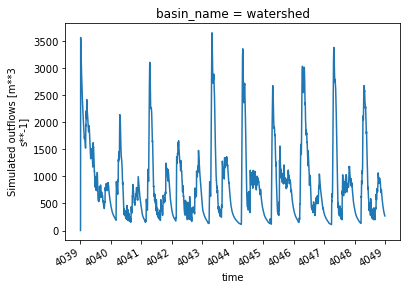

In [123]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [126]:
hydrograph['time']

<xarray.DataArray 'time' (time: 3651)>
array(['2070-01-01T00:00:00.000000000', '2070-01-02T00:00:00.000000000',
       '2070-01-03T00:00:00.000000000', ..., '2079-12-28T00:00:00.000000000',
       '2079-12-29T00:00:00.000000000', '2079-12-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2070-01-01 2070-01-02 ... 2079-12-30
Attributes:
    standard_name:  time

## If we want, we can also download the simulation data and analyze it on our own computer, software and tools:

In [ ]:
# Re-extract the WPS Server response, but this time set the "asobj" to False to return the file path.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=False)
print(hydrograph)
print(storage)
print(solution)
print(diagnostics)
print(rv)